In [4]:
%load_ext autoreload
%autoreload 2
# import torch; torch.manual_seed(955)
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from dataGen import Gen, FastGen, Gen2
from Encoders import LongShort_TCVAE_Encoder, RnnEncoder, MST_VAE_Encoder, MST_VAE_Encoder_dist
from Decoders import LongShort_TCVAE_Decoder, RnnDecoder, MST_VAE_Decoder, MST_VAE_Decoder_dist
from vae import Variational_Autoencoder, VQ_MST_VAE, VQ_Quantizer
from utils import * #train_on_effect, generate_data, extract_parameters, suppress_prints, add_mu_std
from train import *
import argparse
import numpy as np
import matplotlib.pyplot as plt
import pprint
torch.set_printoptions(sci_mode=False)

# all parameters for generating the time series should be configured in this cell
        
p=2       
args = GENV(n_channels=1,
            latent_dims=10,
            n_samples=100,
            shuffle=False,
            periode=p,
            L=288*p,
            min_max=False,
            num_layers=3,
            ß=10,
            modified=True,
            first_kernel=288)
effects = {
    "Pulse": {
        "occurances":1,
        "max_amplitude":5,   
        "interval":40,
        "start":None
        },
    "Trend": {
        "occurances":10,
        "max_slope":0.002,
        "type":"linear",
        "start":None
        },
    "Seasonality": {
        "occurances":10,
        "frequency_per_week":(7, 14), # min and max occurances per week
        "amplitude_range":(5, 20),
        "start":-5
        },
    "std_variation": {
        "occurances":0,
        "max_value":10,
        "interval":30,
        "start":None
        },
    "channels_coupling":{
        "occurances":0,
        "coupling_strengh":20
        },
    "Noise": {
        "occurances":0,
        "max_slope":0.005,
        "type":"linear"
        }
    }

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from importlib import reload
from Encoders import LongShort_TCVAE_Encoder#, RnnEncoder, MST_VAE_Encoder, MST_VAE_Encoder_dist
from Decoders import LongShort_TCVAE_Decoder#, RnnDecoder, MST_VAE_Decoder, MST_VAE_Decoder_dist
from vae import Variational_Autoencoder, VQ_MST_VAE, VQ_Quantizer
args.num_embed = 512 # args.enc_out**2 
args.robust = False
vae = Variational_Autoencoder(args,
                            v_encoder = LongShort_TCVAE_Encoder, #MST_VAE_Encoder,
                            v_decoder = LongShort_TCVAE_Decoder #MST_VAE_Decoder,
                           )
vq = VQ_MST_VAE(args,
                v_encoder = LongShort_TCVAE_Encoder, #MST_VAE_Encoder,
                v_decoder = LongShort_TCVAE_Decoder, #MST_VAE_Decoder,
                v_quantizer = VQ_Quantizer) #10 5

vae = vae.to(args.device)
vq = vq.to(args.device)

opt_vae = optim.Adam(vae.parameters(), lr = 0.002043529186448577) # 0.005043529186448577 0.006819850049647945
opt_vq = optim.Adam(vq.parameters(), lr = 0.002043529186448577) # 0.005043529186448577 0.006819850049647945

generating:  1
generating:  2
generating:  3
generating:  4
generating:  5
generating:  6
generating:  7
generating:  8
generating:  9


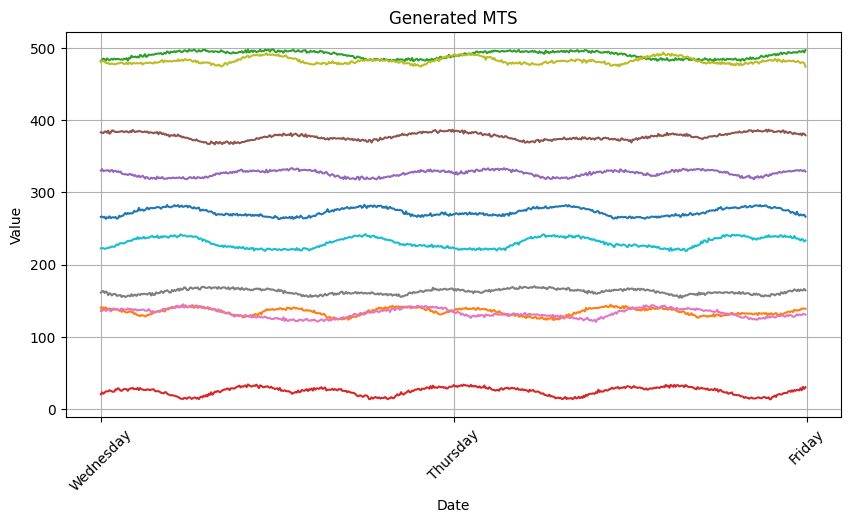

In [6]:
train_data, val_data, test_data, X = generate_labeled_data(args,
                                                           effects,
                                                           effect="Seasonality",
                                                           occurance=3,
                                                           return_gen=True,
                                                           anomalies=False)

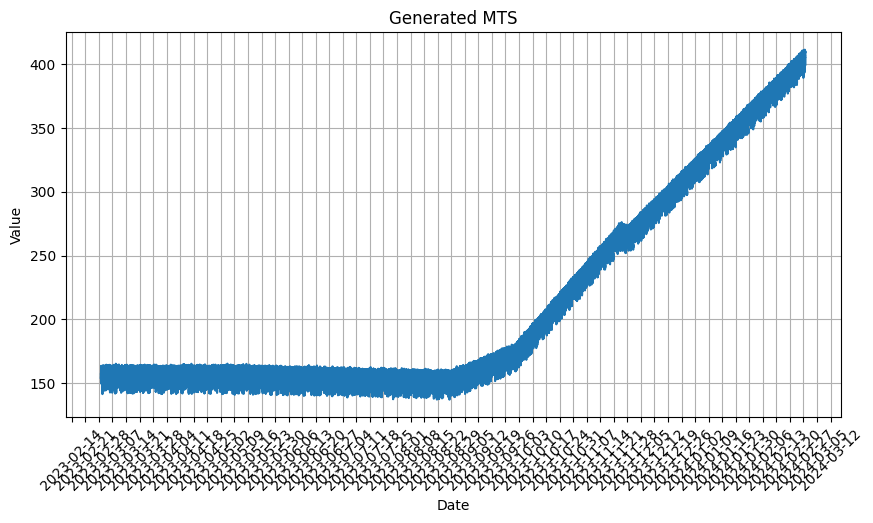

In [7]:
train_data_long, val_data_long, test_data_long, X_long = generate_long_data(args,
                                                                            effects,
                                                                            effect="both",
                                                                            occurance=5,
                                                                            return_gen=True,
                                                                            anomalies=False)

In [8]:
#Get actual frequencies per week and store them in numpy array
x_long, params_long, e_params_long = X_long.parameters()
frs_long = e_params_long["Seasonality"]["frequency_per_week"][0]
frs_long = np.array(frs_long)

# Get original and reconstructed TS both normalized for vae
Origin_norm_long, REC_norm_long, _ = rebuild_TS_non_overlapping(vae, train_data_long, args, keep_norm=True)

# Denoise 
denoised_rec_long = denoise_data(REC_norm_long.T.cpu())
denoised_orig_long = denoise_data(Origin_norm_long.T.cpu())

# Generate new training loader with denoised data
train_data_long_denoised = DataLoader(StridedWindow(torch.from_numpy(denoised_orig_long), args),  # slidingWindow, stridedWindow
                            batch_size=args.bs,  # 59, # 22
                            shuffle=False,
                            drop_last=False
                            )

In [9]:
#Get actual frequencies per week and store them in numpy array
x, params, e_params = X.parameters()
frs = e_params["Seasonality"]["frequency_per_week"]
frs = np.array(frs)

# Get original and reconstructed TS both normalized and not for vae and VQ
Origin_vae_norm, REC_vae_norm, _ = rebuild_TS(vae, train_data, args, keep_norm=True)
Origin_vae, REC_vae, z = rebuild_TS(vae, train_data, args, keep_norm=False)

Origin_vq_norm, REC_vq_norm, _ = rebuild_TS(vq, train_data, args, keep_norm=True)
Origin_vq, REC_vq, indices = rebuild_TS(vq, train_data, args, keep_norm=False)

# Get the labels array for training data
labels = extract_parameters(args, e_params=e_params, effects=effects)
labels = add_mu_std(labels, params)
train_labels = labels[:Origin_vae_norm.shape[0]]
                      
# Denoise 
denoised_rec = denoise_data(REC_vae_norm.cpu())
denoised_orig = denoise_data(Origin_vae_norm.cpu())

# Generate new training loader with denoised data
train_data_denoised = DataLoader(NoWindow(torch.from_numpy(denoised_orig), args, train_labels, norm=True),  # slidingWindow, stridedWindow
                            batch_size=args.bs,  # 59, # 22
                            shuffle=False,
                            drop_last=False
                            )

In [30]:
acf = generate_acf(Origin_vae_norm)
# freqs = get_frequencies_per_week(vae, train_data, args, n=3)
# freqs_long = get_frequencies_per_week_long(vae, train_data_long, args, n=5)
# freqs = get_frequencies_per_week_acf(vae, Origin_vae_norm, args, 3)
# # Get global and per Window mean and std  
# mean_global = data.mean(dim=1, keepdim=True)
# std_global = data.std(dim=1, keepdim=True)
# for i, (data, label, norm) in enumerate(train_data_long):
#     denorm_data = revert_standarization(data, norm)
#     mean_window = denorm_data.mean(dim=-1)
#     std_window = denorm_data.std(dim=-1)

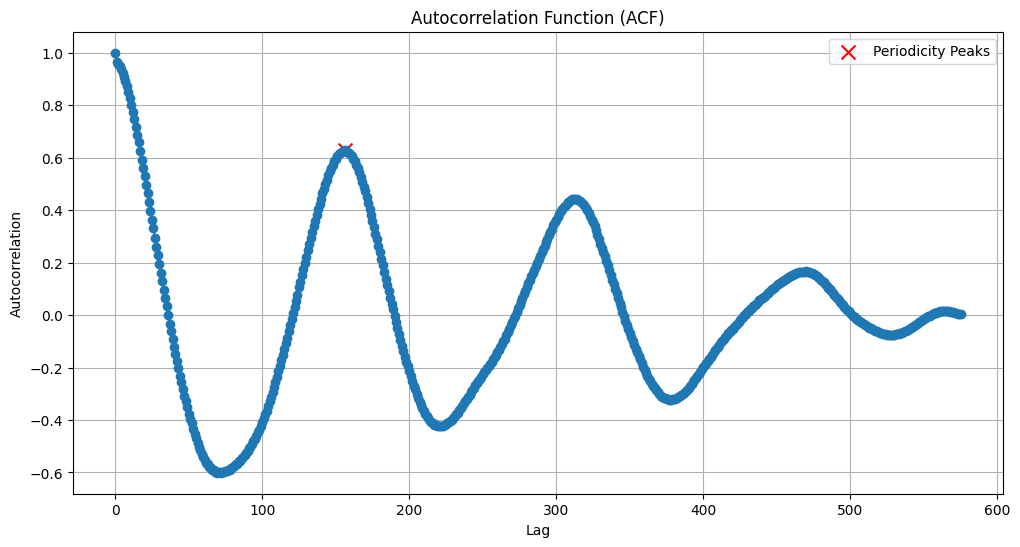

Identified periodicities: [12.923076923076923]


array([12.92307692])

In [44]:
autocorr = acf[0,0]
identify_frequencies(autocorr, args, 3, plot=True)

In [45]:
frs[0]

array([ 9.97842543, 12.95177583, 12.7669292 ])

In [33]:
for i in range(Origin_vae_norm.shape[0]):
        for j in range(Origin_vae_norm.shape[1]):
            autocorr = acf[i, j]
            print(identify_frequencies(autocorr, args, 3, plot=False))

[12.92307692]
[12.36809816]
[8.2962963]
[12.92307692]
[12.67924528]
[7.81395349]
[9.83414634]
[33.04918033  8.76521739  7.66539924]
[24.58536585 12.44444444  8.26229508]
[12.75949367]
[11.5862069]
[21.44680851 12.44444444 11.01639344]
[]
[11.13812155]
[12.92307692]
[8.88105727]
[13.35099338 10.44559585]
[9.55450237]
[8.36514523]
[12.92307692  7.07368421]
[12.14457831]
[12.36809816]
[21.         10.44559585  7.07368421]
[12.84076433]
[15.50769231  7.875     ]
[12.14457831]
[10.13065327]
[10.28571429]
[11.13812155]
[8.92035398]
[8.2962963]
[11.45454545]
[24.         11.65317919  7.81395349]
[8.12903226]
[9.73913043 7.84435798]
[10.13065327]
[10.8972973]
[9.04035874]
[7.41176471]
[27.24324324 13.44        8.88105727]
[12.6]
[12.07185629]
[10.61052632  7.46666667]
[9.73913043]
[10.18181818]
[15.38931298  7.93700787]
[28.3943662  13.80821918  9.29032258]
[8.96]
[13.35099338]
[11.3258427]
[11.07692308]
[11.2         9.98019802  8.84210526]
[13.44  8.96]
[20.57142857 12.14457831  7.27797834]


In [19]:
frs_long

array([ 8.62073921, 13.93348035, 10.61257237, 13.05540905,  8.62437893])

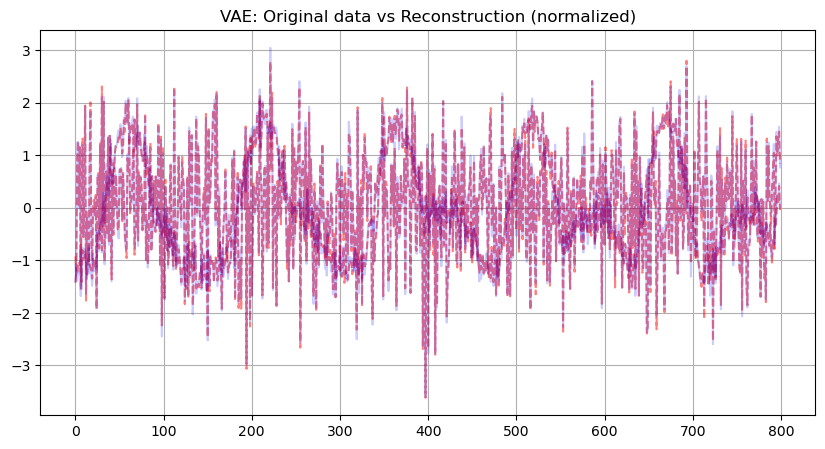

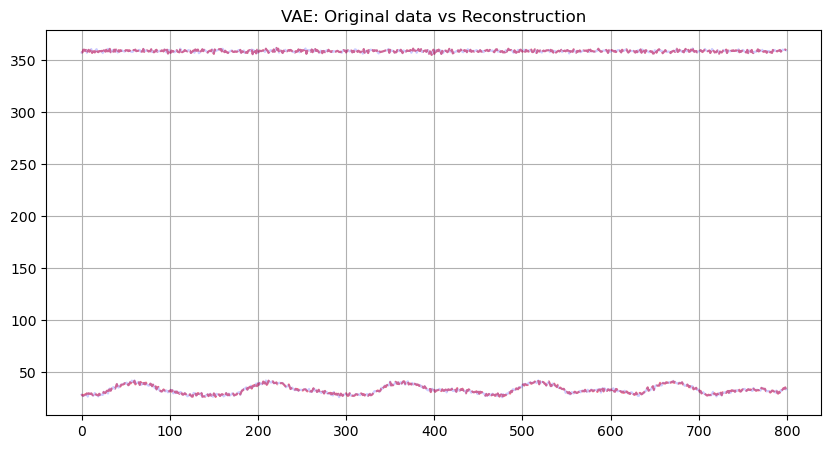

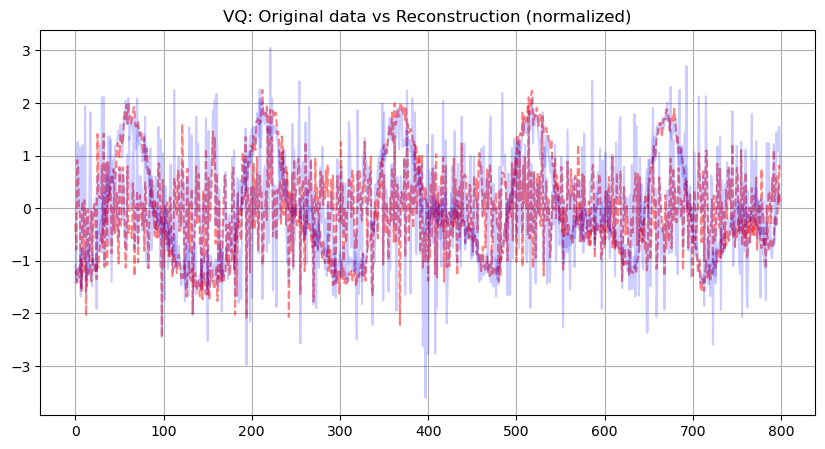

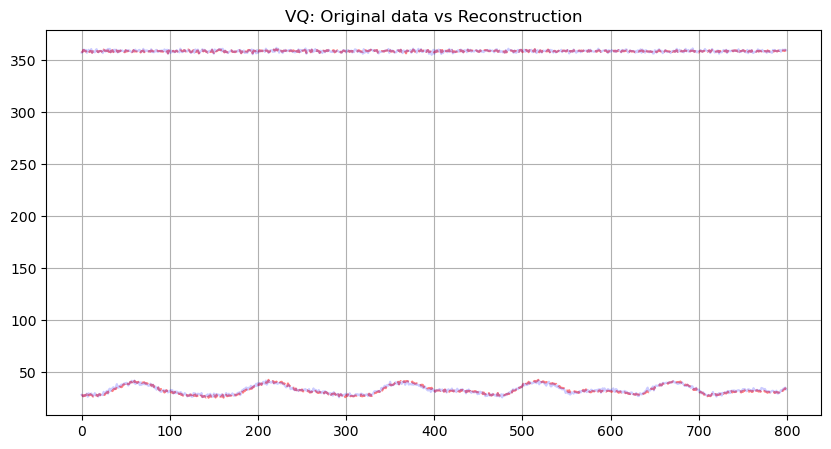

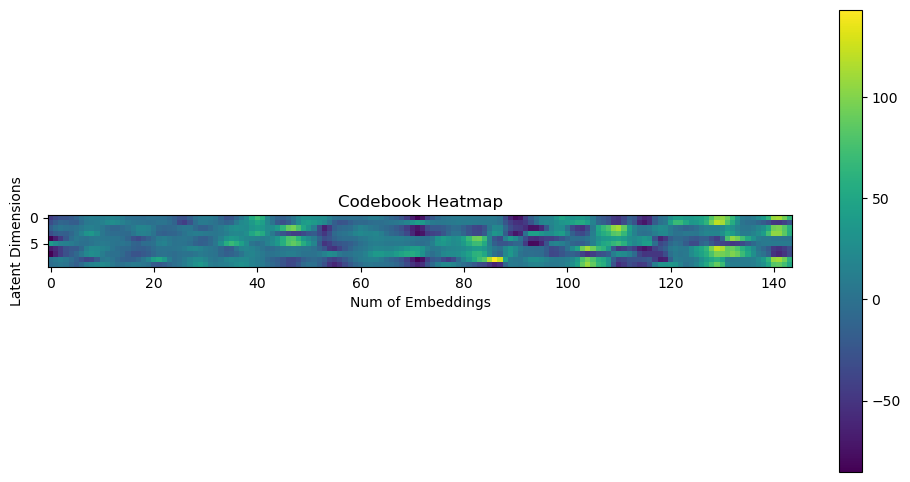

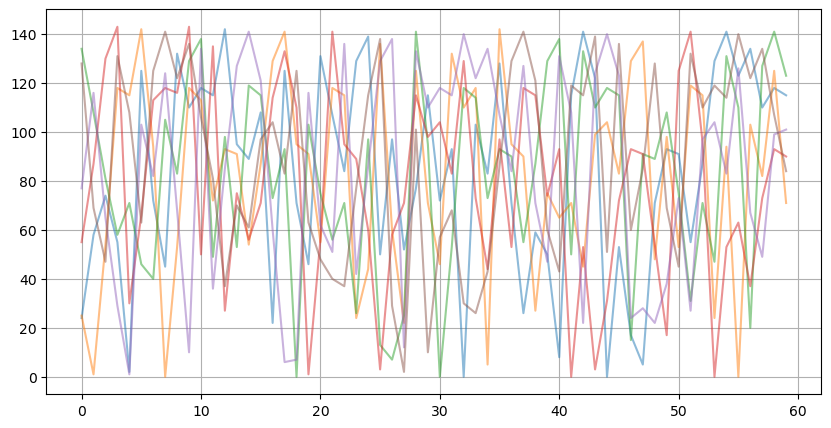

====> VAE: Sample 901 Average loss: 0.2840
====> VQ: Sample 901 Average loss: 2.0885
Train Epoch: 902 [0/1 (0%)]	Loss: 41.162274	 True Loss: 5968.529785
Train Epoch: 902 [0/1 (0%)]	Loss: 295.125458	 True Loss: 42793.191406
====> VAE: Sample 902 Average loss: 0.2839
====> VQ: Sample 902 Average loss: 2.0353
Train Epoch: 903 [0/1 (0%)]	Loss: 40.837180	 True Loss: 5921.391113
Train Epoch: 903 [0/1 (0%)]	Loss: 292.751886	 True Loss: 42449.023438
====> VAE: Sample 903 Average loss: 0.2816
====> VQ: Sample 903 Average loss: 2.0190
Train Epoch: 904 [0/1 (0%)]	Loss: 40.846555	 True Loss: 5922.750488
Train Epoch: 904 [0/1 (0%)]	Loss: 304.167295	 True Loss: 44104.257812
====> VAE: Sample 904 Average loss: 0.2817
====> VQ: Sample 904 Average loss: 2.0977
Train Epoch: 905 [0/1 (0%)]	Loss: 41.167039	 True Loss: 5969.220703
Train Epoch: 905 [0/1 (0%)]	Loss: 300.081600	 True Loss: 43511.832031
====> VAE: Sample 905 Average loss: 0.2839
====> VQ: Sample 905 Average loss: 2.0695
Train Epoch: 906 [0/1 (

Train Epoch: 940 [0/1 (0%)]	Loss: 40.355475	 True Loss: 5851.543945
Train Epoch: 940 [0/1 (0%)]	Loss: 294.686315	 True Loss: 42729.515625
====> VAE: Sample 940 Average loss: 0.2783
====> VQ: Sample 940 Average loss: 2.0323
Train Epoch: 941 [0/1 (0%)]	Loss: 40.443871	 True Loss: 5864.361328
Train Epoch: 941 [0/1 (0%)]	Loss: 281.116406	 True Loss: 40761.878906
====> VAE: Sample 941 Average loss: 0.2789
====> VQ: Sample 941 Average loss: 1.9387
Train Epoch: 942 [0/1 (0%)]	Loss: 40.277522	 True Loss: 5840.240723
Train Epoch: 942 [0/1 (0%)]	Loss: 295.859321	 True Loss: 42899.601562
====> VAE: Sample 942 Average loss: 0.2778
====> VQ: Sample 942 Average loss: 2.0404
Train Epoch: 943 [0/1 (0%)]	Loss: 40.125418	 True Loss: 5818.185547
Train Epoch: 943 [0/1 (0%)]	Loss: 283.831546	 True Loss: 41155.574219
====> VAE: Sample 943 Average loss: 0.2767
====> VQ: Sample 943 Average loss: 1.9575
Train Epoch: 944 [0/1 (0%)]	Loss: 40.344164	 True Loss: 5849.903809
Train Epoch: 944 [0/1 (0%)]	Loss: 289.60

Train Epoch: 977 [0/1 (0%)]	Loss: 39.685671	 True Loss: 5754.422363
Train Epoch: 977 [0/1 (0%)]	Loss: 299.030550	 True Loss: 43359.429688
====> VAE: Sample 977 Average loss: 0.2737
====> VQ: Sample 977 Average loss: 2.0623
Train Epoch: 978 [0/1 (0%)]	Loss: 39.641996	 True Loss: 5748.089355
Train Epoch: 978 [0/1 (0%)]	Loss: 288.516918	 True Loss: 41834.953125
====> VAE: Sample 978 Average loss: 0.2734
====> VQ: Sample 978 Average loss: 1.9898
Train Epoch: 979 [0/1 (0%)]	Loss: 39.839665	 True Loss: 5776.751465
Train Epoch: 979 [0/1 (0%)]	Loss: 287.627478	 True Loss: 41705.984375
====> VAE: Sample 979 Average loss: 0.2748
====> VQ: Sample 979 Average loss: 1.9836
Train Epoch: 980 [0/1 (0%)]	Loss: 40.036658	 True Loss: 5805.315430
Train Epoch: 980 [0/1 (0%)]	Loss: 298.270339	 True Loss: 43249.199219
====> VAE: Sample 980 Average loss: 0.2761
====> VQ: Sample 980 Average loss: 2.0570
Train Epoch: 981 [0/1 (0%)]	Loss: 39.759947	 True Loss: 5765.192383
Train Epoch: 981 [0/1 (0%)]	Loss: 298.63

In [74]:
args.min_max= False
np.set_printoptions(suppress=True)
VAE_losses = []
VQ_losses = []

for epoch in range(1, 1000):
    loss_vae = train(vae, train_data_long, args, opt_vae, epoch)
    loss_vq = train(vq, train_data_long, args, opt_vq, epoch)
    
    if epoch%100 == 1:
        display.clear_output(wait=True)
        show_results_long(vae, train_data_long, args)
        show_results_long(vq, train_data_long, args, vq=True)
        
    VAE_losses.append(loss_vae)
    VQ_losses.append(loss_vq)
                
    print('====> VAE: Sample {} Average loss: {:.4f}'.format(epoch, loss_vae / len(train_data_long.dataset)))
    print('====> VQ: Sample {} Average loss: {:.4f}'.format(epoch, loss_vq / len(train_data_long.dataset)))

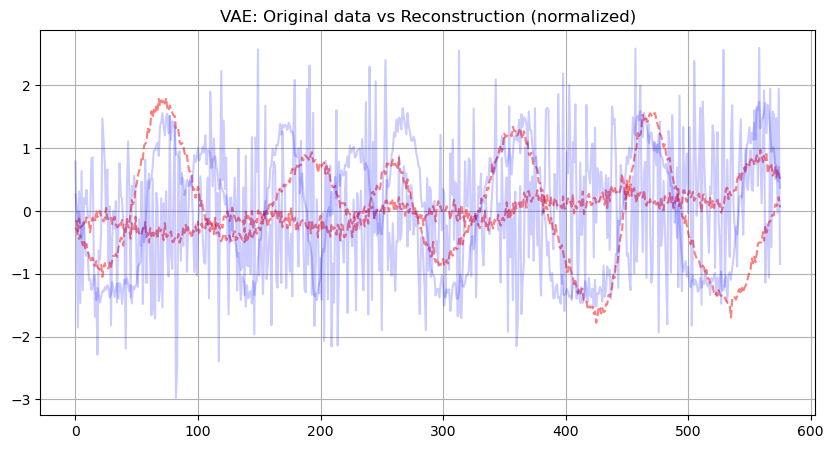

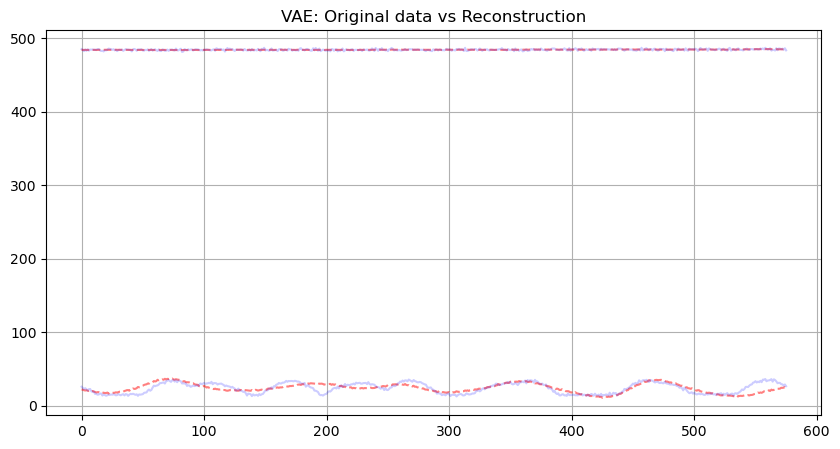

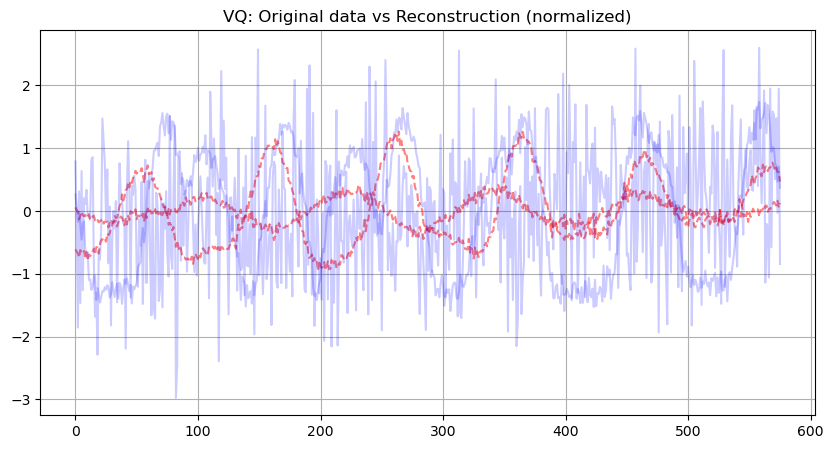

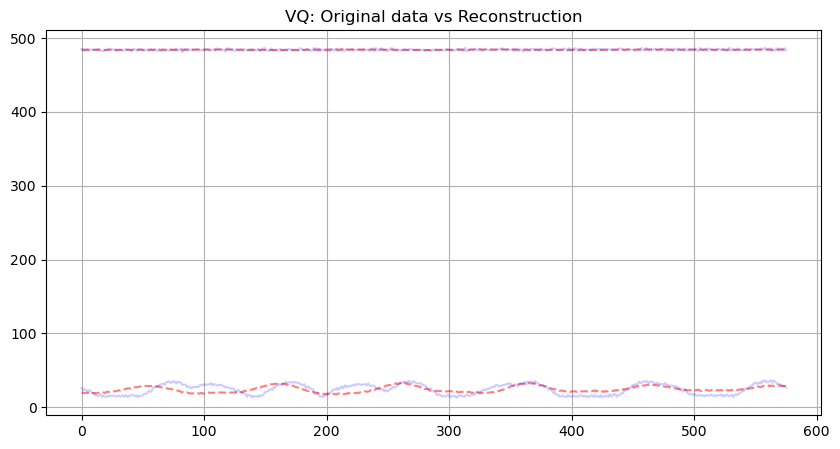

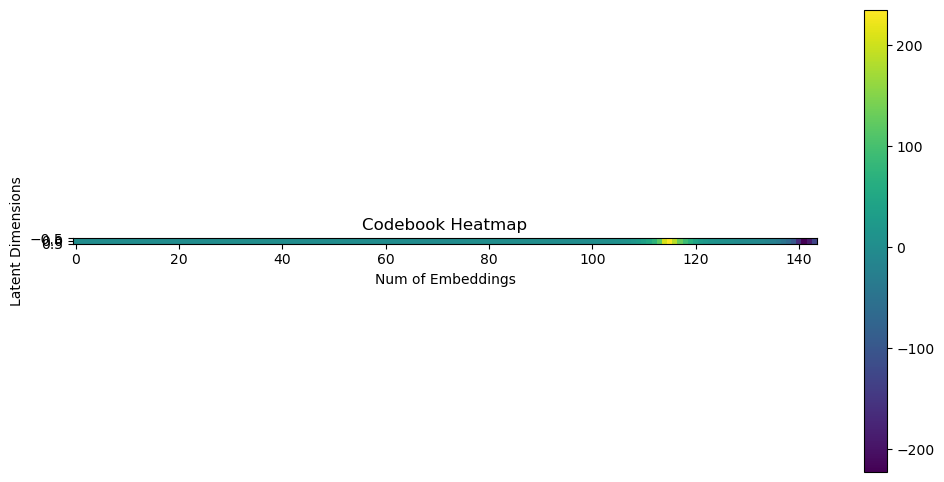

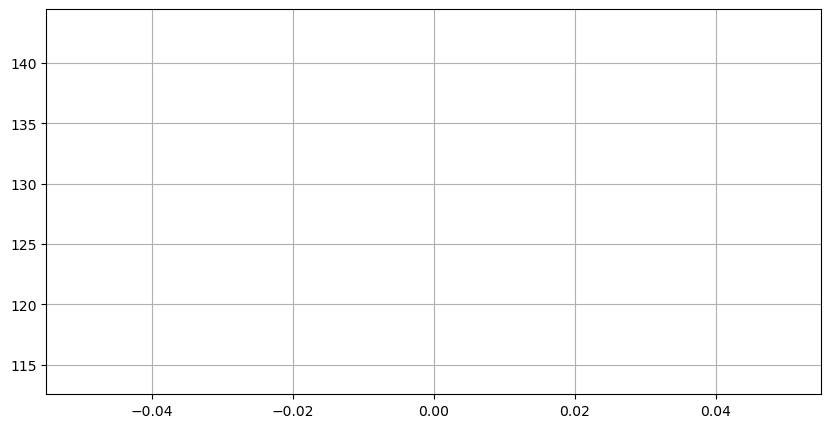

====> VAE: Sample 91 Average loss: 0.1212
====> VQ: Sample 91 Average loss: 0.1838
Train Epoch: 92 [0/16 (0%)]	Loss: 462.099304	 True Loss: 118297.421875
Train Epoch: 92 [0/16 (0%)]	Loss: 711.662659	 True Loss: 182185.640625
====> VAE: Sample 92 Average loss: 0.1209
====> VQ: Sample 92 Average loss: 0.1834
Train Epoch: 93 [0/16 (0%)]	Loss: 462.034668	 True Loss: 118280.875000
Train Epoch: 93 [0/16 (0%)]	Loss: 710.233765	 True Loss: 181819.843750
====> VAE: Sample 93 Average loss: 0.1207
====> VQ: Sample 93 Average loss: 0.1831
Train Epoch: 94 [0/16 (0%)]	Loss: 460.932861	 True Loss: 117998.812500
Train Epoch: 94 [0/16 (0%)]	Loss: 712.921997	 True Loss: 182508.031250
====> VAE: Sample 94 Average loss: 0.1204
====> VQ: Sample 94 Average loss: 0.1824
Train Epoch: 95 [0/16 (0%)]	Loss: 460.560638	 True Loss: 117903.523438
Train Epoch: 95 [0/16 (0%)]	Loss: 706.635010	 True Loss: 180898.562500
====> VAE: Sample 95 Average loss: 0.1202
====> VQ: Sample 95 Average loss: 0.1824
Train Epoch: 96 [

In [34]:
np.set_printoptions(suppress=True)
VAE_losses = []
VQ_losses = []

for epoch in range(1, 100):
    loss_vae = train(vae, train_data, args, opt_vae, epoch)
    loss_vq = train(vq, train_data, args, opt_vq, epoch)
    
    if epoch%10 == 1:
        display.clear_output(wait=True)
        show_results(vae, train_data, args)
        show_results(vq, train_data, args, vq=True)
        
    VAE_losses.append(loss_vae)
    VQ_losses.append(loss_vq)
        
    print('====> VAE: Sample {} Average loss: {:.4f}'.format(epoch, loss_vae / len(train_data.dataset)))
    print('====> VQ: Sample {} Average loss: {:.4f}'.format(epoch, loss_vq / len(train_data.dataset)))

In [39]:
pulses_indexs = indexs[np.where(channels == 1)]
pulses_indexs.sort(axis=0)

plt.plot(pulses_indexs)
plt.plot(anomalies)

(863,)

In [ ]:
n = len(ts)
t = np.arange(n)
scale_factor = 182 *args.split[0]
new_n =41761*2# int(scale_factor * n)


In [81]:
Origin.shape

torch.Size([83520, 2])

In [116]:
acf = generate_acf(Origin_vae_norm.cpu())

In [111]:
60*24*7/(235*5)

8.578723404255319

In [118]:
acf.shape

(800, 1, 576)

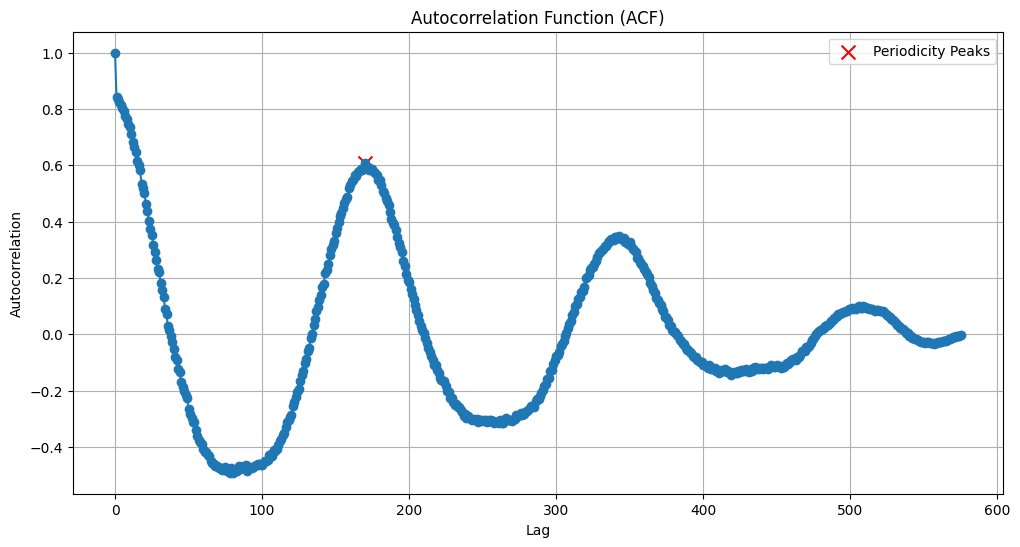

Identified periodicities: [11.858823529411763]
[11.65111656]


In [159]:
k = 46
autocorr = acf[k,0]
identify_frequencies(autocorr, args, 50)
print(frs[k])

In [160]:
from scipy.signal import find_peaks
autocorr = acf[0,0]
# identify_frequencies(autocorr, args, 1)

def identify_frequencies(autocorr, args, n_frequencies=1, plot=True):
    # Find significant peaks in the ACF
    min_to_week = 7*24*60
    max_lag = len(autocorr) // 2
    peaks, _ = find_peaks(autocorr[10:max_lag], distance=20, height=[0,None], plateau_size=1)

    periodicities = peaks[:n_frequencies]+10
    freqs = [(( 1/(periodicity*args.step) ) * min_to_week) for periodicity in periodicities]
    if plot:
        # Plot the autocorrelation function (ACF)
        plt.figure(figsize=(12, 6))
        plt.plot(autocorr, marker='o', linestyle='-')
        plt.title('Autocorrelation Function (ACF)')
        plt.xlabel('Lag')
        plt.ylabel('Autocorrelation')
        plt.grid(True)        

        # Plot the ACF with identified periodicities
        plt.scatter(periodicities, [autocorr[lag] for lag in periodicities], color='red', marker='x', s=100, label='Periodicity Peaks')
        plt.legend()
        plt.show()
        
        # Output the identified periodicities
        print("Identified periodicities:",freqs)
    return np.array(freqs)

In [157]:
frs = e_params["Seasonality"]["frequency_per_week"]
arr = np.array(frs)
arr[0]

array([9.3113152])

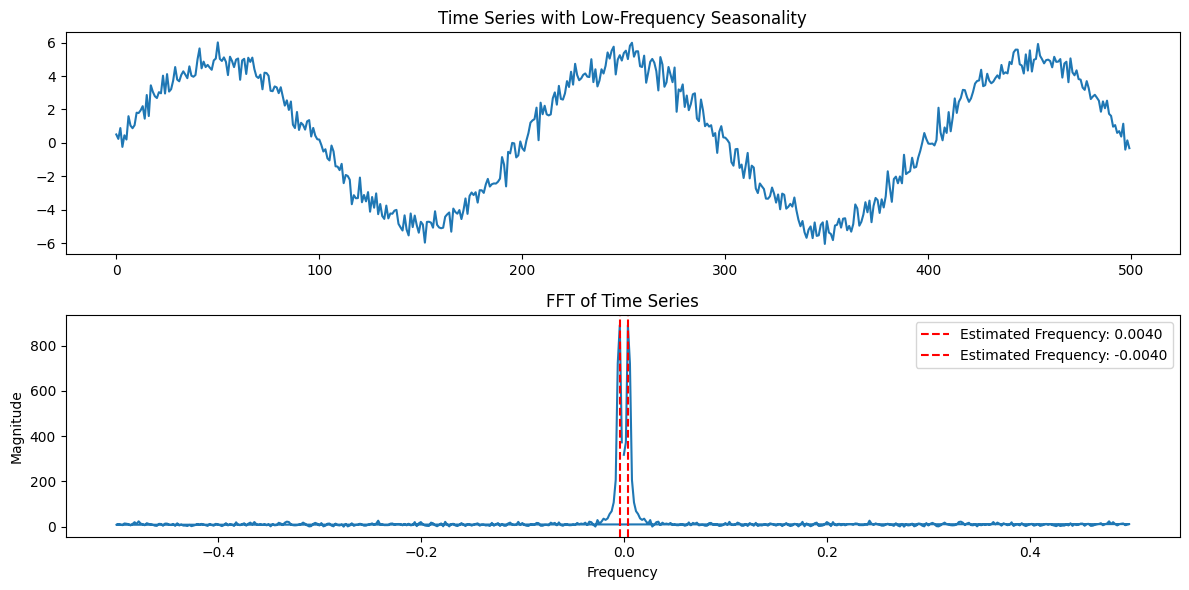

In [140]:
from scipy.signal import find_peaks

# Create a time series with low-frequency seasonality
n = 500
t = np.arange(n)
frequency = 0.005  # Low-frequency seasonality
seasonality = 5 * np.sin(2 * np.pi * frequency * t)
noise = np.random.normal(0, 0.5, n)
time_series = seasonality + noise

# Compute the FFT
fft_result = np.fft.fft(time_series)
sampling_frequency = 1  # Assuming unit sampling frequency
frequencies = np.fft.fftfreq(n, d=1 / sampling_frequency)

# Identify the peaks in the FFT magnitude plot
peaks, _ = find_peaks(np.abs(fft_result), 600)

# Extract corresponding frequencies
peak_frequencies = frequencies[peaks]

# Plot the time series and the estimated frequencies
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t, time_series)
plt.title('Time Series with Low-Frequency Seasonality')

plt.subplot(2, 1, 2)
plt.plot(frequencies, np.abs(fft_result))
plt.title('FFT of Time Series')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')

# Plot the estimated frequencies
for freq in peak_frequencies:
    plt.axvline(x=freq, color='r', linestyle='--', label=f'Estimated Frequency: {freq:.4f}')
plt.legend()

plt.tight_layout()
plt.show()

(1009,)
[ 8  6  7 11 15]
[255.40695 298.44864 699.44946 662.7711  397.8458 ]
[112.  84.  98. 154. 210.]


array([ 9.40703251, 10.85850522, 10.41877301,  7.38420925])

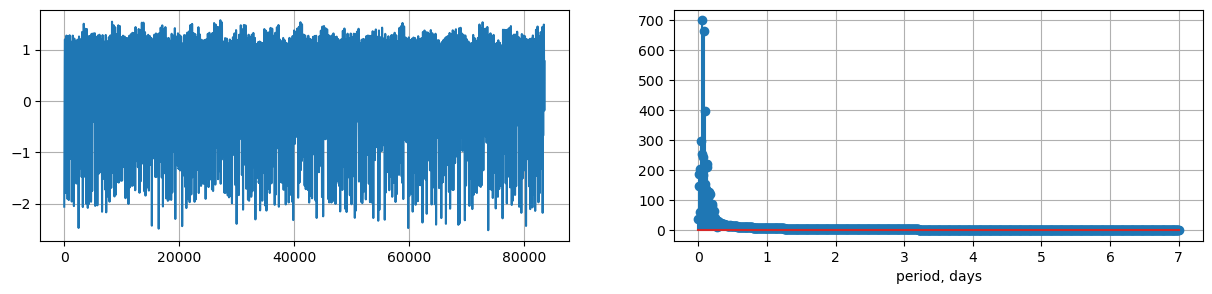

In [220]:
import scipy.fft as sf
import matplotlib.ticker as tck

days = 7
N = 288 * days
# N = denoised.shape[-1]
X = sf.rfft(denoised[0][:N]) #/ N
freqs = sf.rfftfreq(n=N, d=1/(days*2))

print(X.shape)
# Plot signal
fig, axes = plt.subplots(figsize=(15,3), ncols=2)
ax=axes[0]
ax.plot(denoised[0])
# ax.xaxis.set_major_locator(tck.MultipleLocator(50))
ax.grid()

# # Plot DFT
ax=axes[1]
extent = 288*7 -1#288*7#N
ax.set_xlabel('period, days')
# ax.stem(freqs[:extent], abs(X[:extent]))
ax.stem(freqs, abs(X))

# x_locator = MultipleLocator(base=288)
# ax.xaxis.set_major_locator(x_locator)
# ax.set_xticklabels([f'{a}' for a in range(days+1)])
# ticks = ax.get_xticks()
# ax.set_xticklabels([f'{a}' for a in range(1000)])
# ax.invert_xaxis()
ax.grid()
np.set_printoptions(suppress=True)

# print(np.argmax(X))
n=5
max_freq_ind = np.argpartition(np.abs(X), -n)[-n:]
print(max_freq_ind)
print(abs(X[max_freq_ind]))
print(freqs[max_freq_ind]*N)
frs

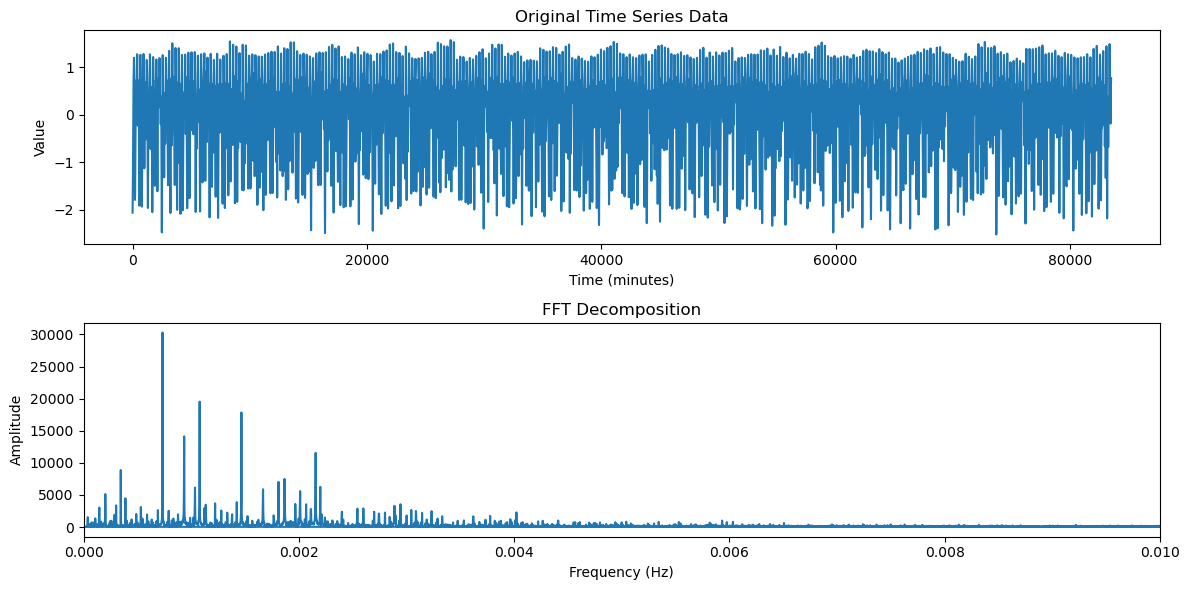

In [221]:
# Define your time series data with a 3-day seasonality
sampling_rate = 5  # 5 minutes between data points
num_points = denoised_orig.shape[0]  # Number of data points (assuming 5-minute intervals in a day)

# Create a time vector in minutes
time = np.arange(0, num_points)# * sampling_rate

# # Create a synthetic time series with a 3-day seasonality
# seasonality_freq = 1 / (3 * 24 * 60)  # Frequency in Hz (3 days in minutes)
# amplitude = 10  # Amplitude of the seasonality
# noise = np.random.normal(0, 1, num_points)  # Add some random noise
# data = amplitude * np.sin(2 * np.pi * seasonality_freq * time) + noise

# Perform FFT on the data
fft_result = np.fft.fft(Origin_norm[:,0].cpu())
frequencies = np.fft.fftfreq(denoised.shape[-1], d=sampling_rate)

# Plot the original data
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time, denoised[0])
plt.title("Original Time Series Data")
plt.xlabel("Time (minutes)")
plt.ylabel("Value")

# Plot the FFT results
plt.subplot(2, 1, 2)
plt.plot(frequencies, np.abs(fft_result))
plt.title("FFT Decomposition")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.xlim(0, 0.01)  # Limit the x-axis to relevant frequencies

plt.tight_layout()
plt.show()


In [222]:
N = 10  # Adjust N as needed
max_amplitude_indices = np.argpartition(np.abs(fft_result), -N)[-N:]
# Get the corresponding frequency in Hertz
max_frequencies = frequencies[max_amplitude_indices]
positive_frequencies = max_frequencies[max_frequencies > 0]
print("Dominant Frequency:", positive_frequencies, "Hz")
np.set_printoptions(suppress=True)



Dominant Frequency: [0.00215517 0.00093391 0.00107759 0.00073276 0.00146552] Hz


In [252]:
import tsfel
# Retrieves a pre-defined feature configuration file to extract all available features
cfg = tsfel.get_features_by_domain("statistical")

# Extract features
X = tsfel.time_series_features_extractor(cfg, Origin_vae[0].T, fs=1/(7*12*24), window_size=args.L, overlap=0)
# Y = tsfel.time_series_features_extractor(cfg, denoised)

*** Feature extraction started ***



*** Feature extraction finished ***


In [254]:
import pandas as pd
pd.options.display.max_rows = None
pd.set_option('display.float_format', lambda x: f'{x:.3f}')
# X.T.columns = ["val"]
# print(arr[15])
# X = pd.DataFrame(X.values.reshape(28, -1)) 
print(X.shape)
# for el in X:
#     val = X[el].item()
#     if (abs(arr[0]- val) <5).any():
#         print(X[el])
#         print(val)
#     print(X[el].item())
X.T

(1, 80)


,0
0_Absolute energy,71499045.671
0_Average power,61.680
0_ECDF Percentile Count_0,115.000
0_ECDF Percentile Count_1,460.000
0_ECDF Percentile_0,347.165
0_ECDF Percentile_1,356.405
0_ECDF_0,0.002
0_ECDF_1,0.003
0_ECDF_2,0.005
0_ECDF_3,0.007
